# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator
from tqdm.auto import tqdm

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

# navigating to cloned repo directory in Colab
%cd {repo} 
from dataprep import transform_indices
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
# restoring original location
%cd - 

# Preparing data

In [2]:
data = get_movielens_data(include_time=True)

In [3]:
training_, holdout_ = leave_one_out(data, target='timestamp', sample_top=True, random_state=0)

assert holdout_.set_index('userid')['timestamp'].ge(
    training_
    .groupby('userid')
    ['timestamp'].max()
).all()

In [4]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')

Filtered 2 invalid observations.


In [5]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)

## PureSVD

In [6]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [7]:
svd_config = {'rank': 200}

V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

In [8]:
V.shape

(3704, 200)

In [9]:
# check orthogonality
np.testing.assert_almost_equal(
    V.T @ V,
    np.eye(svd_config['rank']), decimal=14
)

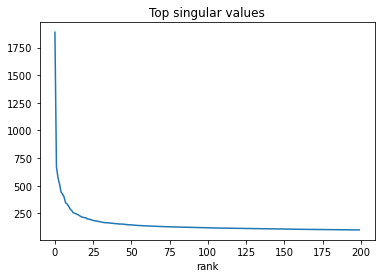

In [10]:
pd.Series(sigma).plot(title='Top singular values', xlabel='rank');

## "Shifted" PureSVD

In [11]:
def build_shifted_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    average_rating = source_matrix.data.mean() # average over all non-zeros
    centered_matrix = source_matrix._with_data(
        source_matrix.data - average_rating
    )

    def shifted_mv(v):
        return centered_matrix.dot(v) + average_rating * v.sum()

    def shifted_rmv(v):
        return centered_matrix.T.dot(v) + average_rating * v.sum()

    shifted_matrix = LinearOperator(
        source_matrix.shape,
        shifted_mv,
        shifted_rmv
    )
    _, s, vt = svds(shifted_matrix, k=config['rank'])
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values    

In [12]:
V_shift, sigma_shift = shifted_params = build_shifted_model(
    svd_config,
    training,
    data_description
)

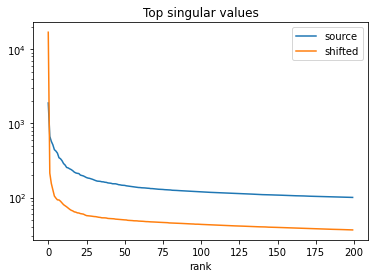

In [13]:
pd.Series(sigma).plot(
    title='Top singular values',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift).plot(
    legend=True,
    label='shifted',
);

Let's sompare top singular value against the theoretical estimation:

In [14]:
sv = training.rating.mean() * np.sqrt(data_description['n_users'] * data_description['n_items'])
print(f'Estimated leading singular value = {sv:.1f}')
print(f'Computed leading singular value = {sigma_shift.max():.1f}')

Estimated leading singular value = 16940.1
Computed leading singular value = 16941.7


Very close!

Let's see how singular values accumulate from the end.

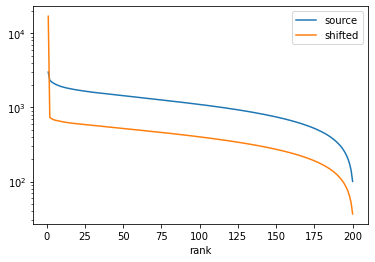

In [15]:
rev_sigma_idx = np.arange(svd_config['rank'], 0, -1)
pd.Series(sigma[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    title='',
    xlabel='rank',
    label='source',
    legend=True,
    logy=True
)
pd.Series(sigma_shift[::-1]**2, index=rev_sigma_idx).cumsum().pow(0.5).plot(
    legend=True,
    label='shifted',
);

Let's stop here for a moment. What are possible conclusions from this graph:
1. we reduced approximation error
2. seems like we'll need lower rank value, as most of the variation is already explained by the first singular triplet.

Let's scrutinize a bit over these two conclusions.

Obviously, singular values indicate general reduction of error, which includes erros computed on unknown ratings. Let's check error only for known ratings.

In [16]:
def rmse(true_ratings, predicted):
    return np.sqrt(np.power(true_ratings - predicted, 2).mean())

def svd_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    user_factors = source_matrix.dot(item_factors)
    return (user_factors[nnz_user] * item_factors[nnz_item, :]).sum(axis=1)

def compute_train_rmse(source_matrix, item_factors):
    return rmse(
        source_matrix.data,
        svd_predict(source_matrix, item_factors)
    )

In [17]:
# PureSVD
train_matrix = matrix_from_observations(training, data_description)
svd_rmse = compute_train_rmse(train_matrix, V)
print(f'svd_rmse={svd_rmse:.2f}')

svd_rmse=1.81


How does it compare to a simple average-rating-prediction model?

In [18]:
average_rating_prediction_error = np.sqrt(np.power(train_matrix.data - train_matrix.data.mean(), 2).mean())
print(f'RMSE of global average rating prediction model: {average_rating_prediction_error:.2f}')

RMSE of global average rating prediction model: 1.12


<font color=green>  

* Which recommendation model (in terms of top-$n$ predictions task) does this average-rating-prediction approach correspond?

</font>

Let's check the rating prediction error for the shifted model now.

In [19]:
def shifted_predict(source_matrix, item_factors):
    nnz_user, nnz_item = source_matrix.nonzero()
    average_rating = source_matrix.data.mean()
    centered_matrix = source_matrix._with_data(
        source_matrix.data - average_rating
    )
    user_factors = centered_matrix.dot(item_factors) + average_rating * item_factors.sum(axis=0)
    return (user_factors[nnz_user] * item_factors[nnz_item, :]).sum(axis=1)

def compute_train_rmse_shifted(source_matrix, item_factors):
    return rmse(
        source_matrix.data, shifted_predict(source_matrix, item_factors)
    )

In [20]:
# Shifted PureSVD
shifted_rmse = compute_train_rmse_shifted(train_matrix, V_shift)
print(f'{shifted_rmse=:.2f}')

shifted_rmse=0.70


Indeed, an improvement is quite substantial.

Let's evaluate with more relevant metrics:

# Evaluation 

## PureSVD

In [22]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_matrix = matrix_from_observations(data, data_description)
    test_users = data_description['test_users']
    scores = test_matrix[test_users, :].dot(item_factors) @ item_factors.T
    return scores

In [23]:
userid = data_description['users']
data_description['test_users'] = test_users = holdout[userid].values
seen_data = training.loc[lambda x: x[userid].isin(test_users)]

svd_scores = svd_model_scoring(svd_params, seen_data, data_description)

In [24]:
downvote_seen_items(svd_scores, seen_data, data_description)

In [25]:
svd_recs = topn_recommendations(svd_scores, topn=10)
model_evaluate(svd_recs, holdout, data_description)

(0.08645246770453793, 0.029794831148756293, 0.37607991360691145)

## Shifted

In [26]:
def shifted_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_matrix = matrix_from_observations(data, data_description)
    test_users = data_description['test_users']
    average_rating = data_description['average_rating']
    centered_matrix = test_matrix[test_users]._with_data(test_matrix.data-average_rating)
    user_factors = centered_matrix.dot(item_factors) + average_rating * item_factors.sum(axis=0)
    scores = user_factors @ item_factors.T
    return scores

In [29]:
data_description['average_rating'] = training['rating'].mean()

shifted_scores = shifted_model_scoring(
    shifted_params,
    seen_data,
    data_description
)

In [30]:
downvote_seen_items(shifted_scores, seen_data, data_description)

In [31]:
shifted_recs = topn_recommendations(shifted_scores)
model_evaluate(shifted_recs, holdout, data_description)

(0.050513415038092084, 0.01849818872011651, 0.31641468682505397)

So, we improved RMSE loss almost by 2.5x, but lost in terms of HitRate by more than 1.5x.

Let's check for a range of rank values,  as the models do not have to have the same rank for optimal quality.

# Grid-search experiment

Let's write a universal evaluation function that takes model parameters and scoring function as input and returns target evaluation metrics.

In [33]:
def evaluate_svd(params, model_scoring):
    # we will use HR as a target metric for tuning
    scores = model_scoring(params, seen_data, data_description)
    downvote_seen_items(scores, seen_data, data_description)
    recs = topn_recommendations(scores, topn=10)
    hr, *_ = model_evaluate(recs, holdout, data_description)
    return hr

In [34]:
ranks = [16, 24, 32, 48, 64, 96, 128, 192, 256]
svd_hr = {'standard': {}, 'shifted': {}}

svd_params = build_svd_model({'rank': max(ranks)}, training, data_description)
shifted_params = build_shifted_model({'rank': max(ranks)}, training, data_description)

for rank in tqdm(ranks):
    # standard model
    item_factors, singvals = svd_params
    rank_params = item_factors[:, :rank], singvals[:rank]
    svd_hr['standard'][rank] = evaluate_svd(rank_params, svd_model_scoring)
    # shifted model
    item_factors, singvals = shifted_params
    rank_params = item_factors[:, :rank], singvals[:rank]    
    svd_hr['shifted'][rank] = evaluate_svd(rank_params, shifted_model_scoring)

100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Let's plot the results.

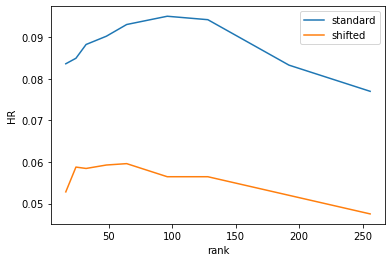

In [35]:
ax = pd.DataFrame(svd_hr).plot()
ax.set_xlabel('rank')
ax.set_ylabel('HR');

Optimal rank values for models:

In [105]:
pd.DataFrame(svd_hr).idxmax()

standard    96
shifted     64
dtype: int64